This is a notebook for probing the relationship between lithologies and the AEM in the OrdKeep area.

Neil Symington
neil.symington@ga.gov.au

In [1]:
%matplotlib inline

In [29]:
import netCDF4
import os
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Point
import shapely.wkt
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy as db
from sqlite3 import dbapi2 as sqlite
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
from hydrogeol_utils import SNMR_utils, spatial_functions, AEM_utils, plotting_utils
import time

In [3]:
# First we will import the AEM conductivity point line data
# The AEM data is in a netCDF file created from a asci files using geophys_utils
# https://github.com/GeoscienceAustralia/geophys_utils
# Start with inversions from the Ord-Bonaparte AEM survey

ncdir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\AEM\EK_nbc_inversions\delivered_20180202\netcdf"
# Open the file with the EM measurements
# Here we use the data response file provided by Niel Christensen
EM_path = os.path.join(ncdir,'NBC_DataResp_cor2d.nc')
ek_em_dataset = netCDF4.Dataset(EM_path)

# Load East Kimberley conductivity model
infile  = os.path.join(ncdir,"NBC_ModelExp_cor2d.nc")
ek_cond = netCDF4.Dataset(infile)


In [4]:
ek_cond

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Dataset read from ASEG-GDF file NBC_ModelExp_cor2d.dat
    Conventions: CF-1.6,ACDD-1.3
    featureType: trajectory
    geospatial_vertical_min: -28.13
    geospatial_vertical_max: 158.25
    geospatial_vertical_units: m
    geospatial_vertical_resolution: point
    geospatial_vertical_positive: up
    history: Converted from ASEG-GDF file NBC_ModelExp_cor2d.dat using definitions file NBC_ModelExp_cor2d.dfn
    date_created: 2018-08-07T09:11:24.410731
    geospatial_east_resolution: point
    geospatial_north_resolution: point
    geospatial_east_min: 413602.8
    geospatial_east_max: 565524.1
    geospatial_east_units: m
    geospatial_north_min: 8244470.0
    geospatial_north_max: 8360774.0
    geospatial_north_units: m
    geospatial_bounds: POLYGON((475123.2000 8244470.0000, 474140.3000 8244475.0000, 473884.2000 8244484.0000, 473841.4000 8244488.0000, 473830.7000 8244490.0000, 472760.40

In [5]:
# Import interpreted lithology data

# Connect to the SNMR database

DB_PATH = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\AEM_lithology\OrdKeep_lithology_interpreted.sqlite"
        
engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)

connection = engine.connect()

# Join the tables and extract all interpreted lithology data

query = 'SELECT l.*, h.Bore_No, h.geometry  FROM bore_header as h JOIN lithology_interpreted as l on h.Bore_No=l.BoreID;'

# Open a pandas dataframe
df_lithology = pd.read_sql_query(query, connection)

# Extract bpore header information for sites that have been interpreted
query = 'SELECT * from bore_header as h WHERE h.Bore_No in (select l.BoreID from lithology_interpreted l);'

# Open a pandas dataframe
df_bores = pd.read_sql_query(query, connection)

In [6]:
# Add easting and northing column from the geometry
df_lithology['easting'] = np.nan
df_lithology['northing'] = np.nan

for index, row in df_lithology.iterrows():
    P = shapely.wkt.loads(row['geometry'])
    x, y = P.x, P.y
    df_lithology.at[index,'easting'] = x
    df_lithology.at[index,'northing'] = y


In [7]:
# Now we will give each observation a membership of bedrock
# where zero is not a memebr, 0.5 is maybe a member and
# 1 is a member

bedrock = ['bedrock', 'weathered bedrock']
pv_seds = ['soil', 'paleochannel fill', 'floodplain seds',
          'soil/colluvium', 'black soil', 'paleovalley fill',
           'paleo-floodplain (paleosol)', 'soil/floodplain seds',
           'soil (?in situ weathered?)']
ambiguous = ['paleovalley fill or ?weathered bedrock?', 
            'floodplain seds or ?weathered bedrock?']

df_lithology['bedrock_membership'] = -999.

for index, row in df_lithology.iterrows():
    if row['Interpretation'] in bedrock:
        df_lithology.at[index,'bedrock_membership'] = 1.
    elif row['Interpretation'] in ambiguous:
        df_lithology.at[index,'bedrock_membership'] = 0.5
    elif row['Interpretation'] in pv_seds:
        df_lithology.at[index,'bedrock_membership'] = 0.
    else:
        print(row['Interpretation'])


In [8]:
# Create a point utils object for the East Kimberley AEM dataset and find the
# nearest neighbour's distance in metres and netCDF point index


ek_point_util = NetCDFPointUtils(ek_cond)

lithology_coords = df_bores[['Easting', 'Northing']].values

distances, indices = ek_point_util.nearest_neighbours(lithology_coords, 
                           points_required=10)


In [9]:
# The next step is to iterate through the sites, 
# use an inverse distance 
# weighting scheme to calculate weights and use this to estimate a representative
# conductivity profile for each bore

# We will save the profiles in a pandas dataframe with the 
# bore id

df_conductivity = pd.DataFrame(columns = {'BoreID',
                                          'Depth_from',
                                          'Depth_to',
                                          'conductivity'})

# Iteratively extract the conductivity profiles

for i, (index, row) in enumerate(df_bores.iterrows()):

    # Get representative conductivity profile
    df_conductivity_profile = AEM_utils.extract_conductivity_profile(ek_cond,
                                                   distances[i],
                                                   indices[i],
                                                   as_dataframe = True)
    # Add the SNMR id to the column
    df_conductivity_profile['BoreID'] = row['Bore_No']
    
    # Append the site profile to the dataframe
    df_conductivity = df_conductivity.append(df_conductivity_profile, sort = True)
    
    # Find the nearest AEM line and add to df_bores
    line_ind =  ek_cond.variables['line_index'][:][indices[i,0]]

    line = ek_cond.variables['line'][line_ind]
    
    df_bores.at[index, 'nearest_line'] = line
    
df_conductivity.reset_index(inplace=True, drop=True)

# Remove problematic nans for the bottom layer which are too deep for our interest
# for this exercise
df_conductivity.dropna(inplace=True)

In [12]:
# Iterate through the acquisitions and interpolate the SNMR intervals onto the AEM intervals
# using an average

# Define the columns that are being interpolated 

interval_columns = ['Depth_from','Depth_to']

# Create a column for interpolated conductivity
df_lithology['conductivity_interpolated'] = np.nan

# Iterate through the lithology logs and find a representative conductvity     
for bore in df_conductivity.BoreID.unique():
    # Define the new intervals based on the lithology intervals
    mask  = df_lithology['BoreID']==bore
    new_intervals = df_lithology[mask][['From_m','To_m']]
    
    # Extract the conductivity data for the site
    mask = df_conductivity['BoreID']==bore
    df_cond = df_conductivity[mask]
    # Interpolate and add the interpolated parameter columns to the dataframe
    df_lithology.at[new_intervals.index,
                'conductivity_interpolated'] = spatial_functions.interpolate_layered_model(df_cond,
                                                               'conductivity',
                                                               interval_columns,
                                                               new_intervals)['conductivity_interpolated']



In [13]:
# Create a log conductivity column
df_lithology['log_conductivity_interpolated'] = np.log10(df_lithology['conductivity_interpolated'].values)

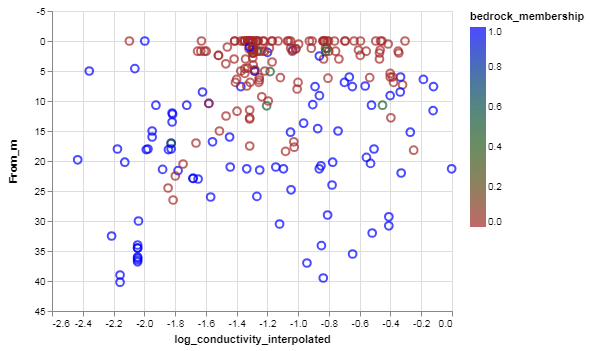

In [14]:
# Scatter plot the 
import altair as alt
alt.renderers.enable('notebook')

domain = [0, 0.5, 1]
rng = ['brown', 'green', 'blue']

alt.Chart(df_lithology).mark_point(size=60).encode(x='log_conductivity_interpolated',
                                        y=alt.Y('From_m', scale=alt.Scale(domain=[45,-5]), axis=alt.Axis(tickCount=10)),
                                        color=alt.Color('bedrock_membership', scale=alt.Scale(domain=domain, range=rng))
                                              )

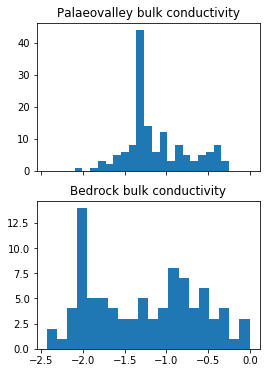

In [15]:
# Create a sub plot with the various histograms

fig, (ax1,ax2) = plt.subplots(2,1, figsize = (4,6), sharex = True)

bedrock_mask = df_lithology['bedrock_membership'] == 1.
pv_mask = df_lithology['bedrock_membership'] == 0.



# Extract log hydraulic K for each unit
cond_br = df_lithology['log_conductivity_interpolated'][bedrock_mask].values
cond_pv = df_lithology['log_conductivity_interpolated'][pv_mask].values
# Assign row and column for the subpots

ax1.hist(cond_pv, bins = 20)
ax2.hist(cond_br, bins = 20)
ax1.set_title('Palaeovalley bulk conductivity')
ax2.set_title('Bedrock bulk conductivity')

plt.show()


In [19]:
# Now lets plot the lithologies onto the AEM sections

lines = df_bores['nearest_line'].unique()

print(len(lines))

25


In [17]:
from hydrogeol_utils.plotting_utils import ConductivitySectionPlot

plots = ConductivitySectionPlot(ek_cond, ek_em_dataset)

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [27]:
# Define some key variables which we want to inteprolate

dat_vars = ['data_values_by_high_moment_gate', 'data_values_by_low_moment_gate']
cond_vars = ['data_residual', 'tx_height_measured', 'depth_of_investigation',
             'conductivity']

# Define the resolution of th sections
xres, yres = 20., 2.


Gridding  25  AEM lines takes  0.0  seconds


In [28]:
# Grid the lines of interest and save into a dictionary

start_time = time.time()

gridded_vars = plots.grid_vars(xres = 20., yres =2., lines=lines,
                               conductivity_variables = cond_vars,
                               data_variables = dat_vars,
                               layer_subdivisions = 4, resampling_method = 'linear',
                               save_hdf5 = False, return_dict = True)

print("Gridding ", str(len(lines)), " AEM lines takes ", str(round(time.time() - start_time,1)), ' seconds')

Gridding  25  AEM lines takes  164.5  seconds


In [31]:

panel_settings = {'panel_1': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 50, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': False, 'vmin': 0, 'vmax': 0.5,
                                             'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 1},
                  
                 'panel_2': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 50, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': 0.001, 'vmax': 0.5,
                                            'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 1}}

In [34]:
# Rename to standard depth from and to column names

## TODO create a more formal description of standards for sub-surface interval data
df_lithology.rename(columns = {'From_m': "Depth_from",
                              "To_m": "Depth_to"}, inplace=True)

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Ad

Plotting  25  AEM lines takes  40.2  seconds


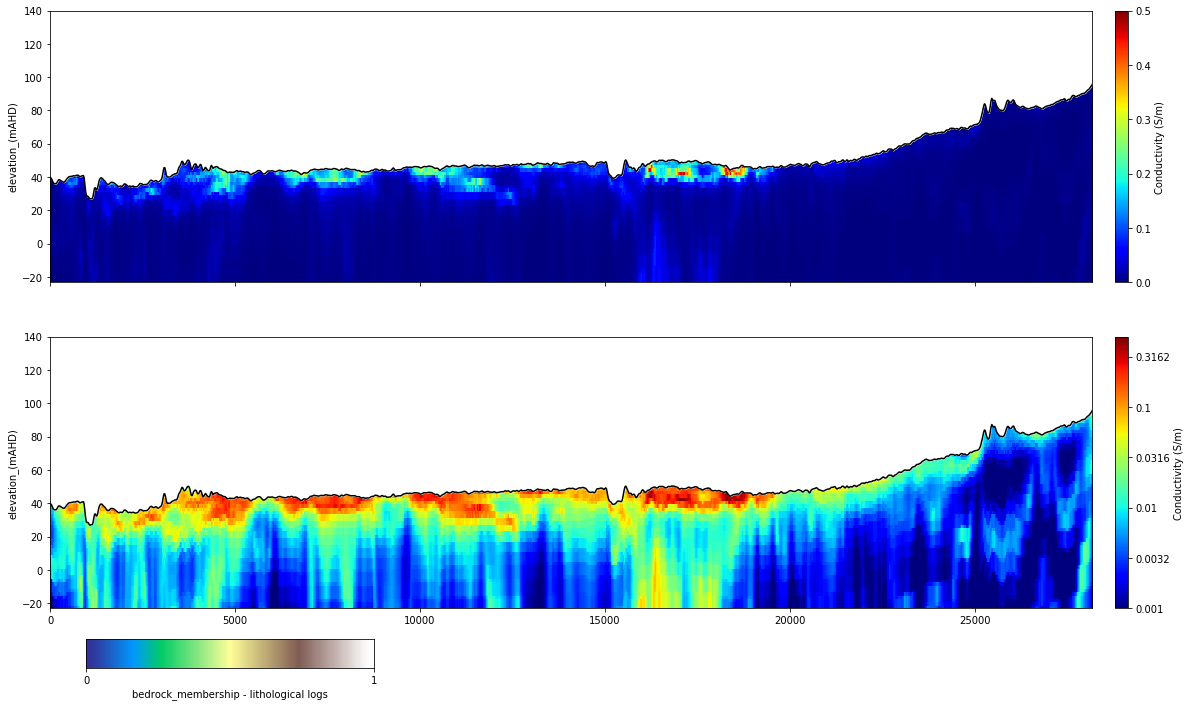

In [36]:
panel_settings = {'panel_1': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 50, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': False, 'vmin': 0, 'vmax': 0.5,
                                             'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 1},
                  
                 'panel_2': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 50, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': 0.001, 'vmax': 0.5,
                                            'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 1}}

outdir = r'\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\AEM_lithology\sections'

start_time = time.time()

for line in lines:
    plt.close()
    fig, ax_array = plt.subplots(len(panel_settings), 1, sharex=True, figsize=(20, 11),
                                     gridspec_kw={'height_ratios':
                                                  plots.unpack_plot_settings(panel_settings,'height_ratio')})
    for i, ax in enumerate(ax_array):
        # PLot a conductivity section
        
        plots.plot_grid(ax, gridded_vars[line], 'conductivity',
                        plots.unpack_plot_settings(panel_settings, "panel_kwargs")[i])
    
        plots.add_sticks(ax, df_lithology, gridded_vars[line], plot_variable = 'bedrock_membership',
                              xy_columns = ['easting', "northing"], cmap = 'terrain', colour_stretch = [0.,1.],
                              stick_thickness = 300.)
    
        # Add the new colourbar for the stick plot
        newax = fig.add_axes([0.15,0.05, 0.2, 0.2], anchor='SW', zorder=1)
    
        plots.add_custom_colourbar(newax, 'terrain', 0.,1., "bedrock_membership - lithological logs")
    
    
    
    plt.savefig(os.path.join(outdir, str(int(line)) + '.png'))

print("Plotting ", str(len(lines)), " AEM lines takes ", str(round(time.time() - start_time,1)), ' seconds')